In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
df = pd.read_csv('../Dataset/India.csv')
df.head(n=5)

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,life_expectancy
0,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,...,NaN,NaN,NaN,NaN,1.380004e+09,450.419,28.2,5.989,3.414,69.66
1,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,...,NaN,NaN,NaN,NaN,1.380004e+09,450.419,28.2,5.989,3.414,69.66
2,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,...,NaN,NaN,NaN,NaN,1.380004e+09,450.419,28.2,5.989,3.414,69.66
3,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,...,NaN,NaN,NaN,NaN,1.380004e+09,450.419,28.2,5.989,3.414,69.66
4,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,0.002,0.001,NaN,...,NaN,NaN,NaN,NaN,1.380004e+09,450.419,28.2,5.989,3.414,69.66


In [3]:
# Fill Nan Values for new_cases smoothed
df.new_cases = df.new_cases.fillna(0.0)
df.new_cases_smoothed = df.new_cases_smoothed.fillna(0.0)

#Split Dataset in train test
data = np.array(df.new_cases).reshape(-1,1)
data_smoothed = np.array(df.new_cases_smoothed).reshape(-1,1)

train_data = data[:-14]
test_data = data[-14:]

train_data_smoothed = data_smoothed[:-14]
test_data_smoothed = data_smoothed[-14:]

train_data.shape, test_data.shape

((334, 1), (14, 1))

### Create Sequence Generator

In [4]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
train_generator = TimeseriesGenerator(train_data, train_data, length=7, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=7, batch_size=1)

train_generator_smoothed = TimeseriesGenerator(train_data_smoothed, train_data_smoothed, length=7, batch_size=7)
test_generator_smoothed = TimeseriesGenerator(test_data_smoothed, test_data_smoothed, length=7, batch_size=7)

### Build SequenceModel

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [7]:
def GetModel(input_shape = (7,1)):
    
    #create a Sequential model object
    model = Sequential()
    
    model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=input_shape))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dense(1))
    
    adam = Adam(lr=1e-2)
    model.compile(optimizer=adam, loss='mean_squared_error')
    
    return model

def Train(model, train, validation):
    model.fit(train, epochs=20, steps_per_epoch=15, validation_data = validation)
    return model

def Prediction(model, train, test):
    prediction = []
    current_batch = train[-7:]
    current_batch = current_batch.reshape((1,7,1))
    
    for i in range(len(test)):
        pred = model.predict(current_batch)
        prediction.append(pred[0][0])
        current_batch = np.append(current_batch[:,1:,], [pred], axis=1)
        
    #Plot the prediction
    plt.rcParams['figure.figsize'] = (16,6)
    
    plt.plot(np.arange(1,15),list(test),label='Actual', linestyle='dashed')
    plt.plot(np.arange(1,15),prediction,label='predicted', linestyle='dashed')
    plt.title("COVID-19 Forecast/Prediction :: 14 days", fontsize=40)
    plt.legend()
    plt.show()

Epoch 1/20
15/15 [==============================] - 1s 59ms/step - loss: 1137077760.0000 - val_loss: 237695568.0000
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 2084776320.0000 - val_loss: 128388464.0000
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 615217920.0000 - val_loss: 142894880.0000
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1267827584.0000 - val_loss: 255086544.0000
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 347140768.0000 - val_loss: 104843224.0000
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 272612160.0000 - val_loss: 171017440.0000
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 176110192.0000 - val_loss: 107863352.0000
Epoch 8/20
15/15 [==============================] - 0s 16ms/step - loss: 65661392.0000 - val_loss: 322202976.0000
Epoch 9/20
15/15 [==============================] - 0s 14ms/step - loss: 71149

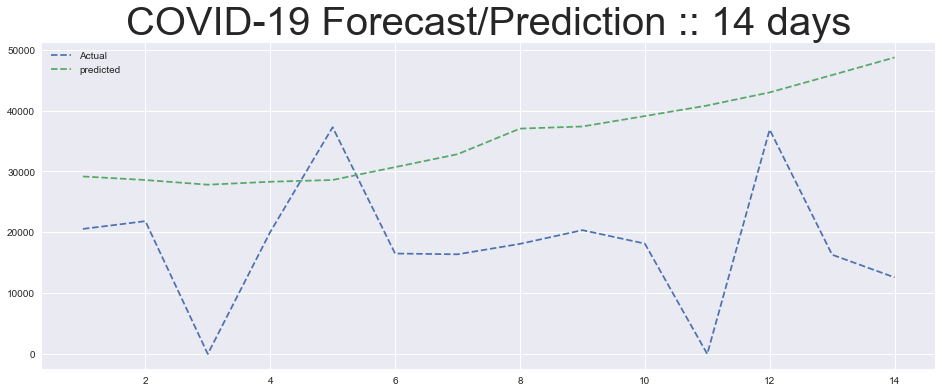

In [8]:
model = GetModel(input_shape=(7,1))
model = Train(model=model, train=train_generator, validation=test_generator)
Prediction(model, train=train_data, test=test_data)